# UNSPLASH + SB + SAM Setup

In [2]:
import torch
import matplotlib.pyplot as plt
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid
from transformers import SamModel, SamProcessor
from PIL import Image, ImageFilter
import numpy as np

image_w = 400
unsplash_image = f"https://images.unsplash.com/photo-1727884747982-4532ed1cb541?q=80&w={image_w}&auto=format&fit=crop"

if (torch.cuda.is_available()):
    device = "cuda"
elif (torch.backends.mps.is_available()):
    device = "mps"
else:
    device = "cpu"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
sam_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [4]:
inpainting_pipeline = AutoPipelineForInpainting.from_pretrained(
    # "kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16

    # TODO: try SB 3 and SBXL
    "stabilityai/stable-diffusion-2-inpainting", torch_dtype=torch.float16
)

inpainting_pipeline.to(device)

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stabilityai/stable-diffusion-2-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## SAM

Inspired by:
- https://github.com/huggingface/notebooks/blob/main/examples/segment_anything.ipynb
- https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
- https://colab.research.google.com/drive/1B7L4cork9UFTtIB02EntjiZRLYuqJS2b#scrollTo=LtZghyHoJabf

In [5]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_masks_on_image(raw_image, masks, scores):
  if len(masks.shape) == 4:
    masks = masks.squeeze()
  if scores.shape[0] == 1:
    scores = scores.squeeze()

  nb_predictions = scores.shape[-1]
  fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

  for i, (mask, score) in enumerate(zip(masks, scores)):
    mask = mask.cpu().detach()
    axes[i].imshow(np.array(raw_image))
    show_mask(mask, axes[i])
    axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
    axes[i].axis("off")
  plt.show()

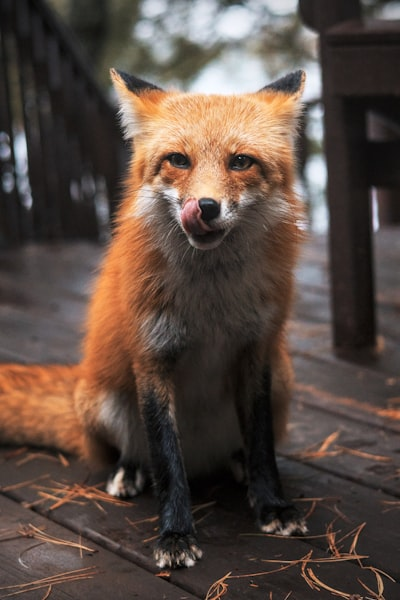

In [6]:
image = load_image(unsplash_image)
image

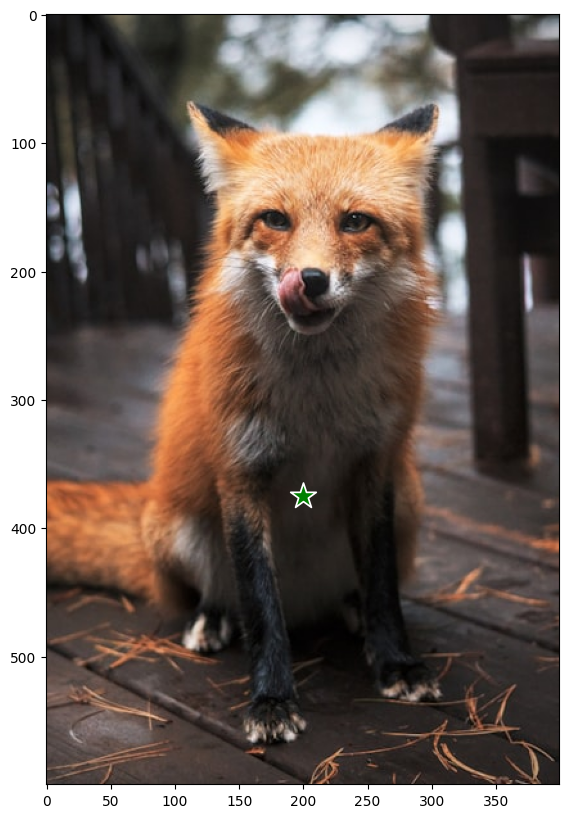

In [7]:
# Setting up a point on the image to indicate to SAM what we want to segment.
input_points = [[[image_w / 2, 375]]]
show_points_on_image(image, input_points[0])

In order to avoid computing multiple times the same image embeddings, we will compute it only once, and use these embeddings to directly feed them to the model for faster inference

In [8]:
inputs = sam_processor(image, return_tensors="pt").to(device)
image_embeddings = sam_model.get_image_embeddings(inputs["pixel_values"])

if (device == "mps"):
    image_embeddings = image_embeddings.to(torch.float32)

In [9]:
inputs = sam_processor(image, input_points=input_points, return_tensors="pt")

# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

# Metal doesn't support double precision floats (float64)
if (device == "mps"):
    inputs.update({"input_points": inputs.input_points.to(torch.float32)})

inputs = inputs.to(device)

In [10]:
with torch.no_grad():
    outputs = sam_model(**inputs)

masks_ = sam_processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores

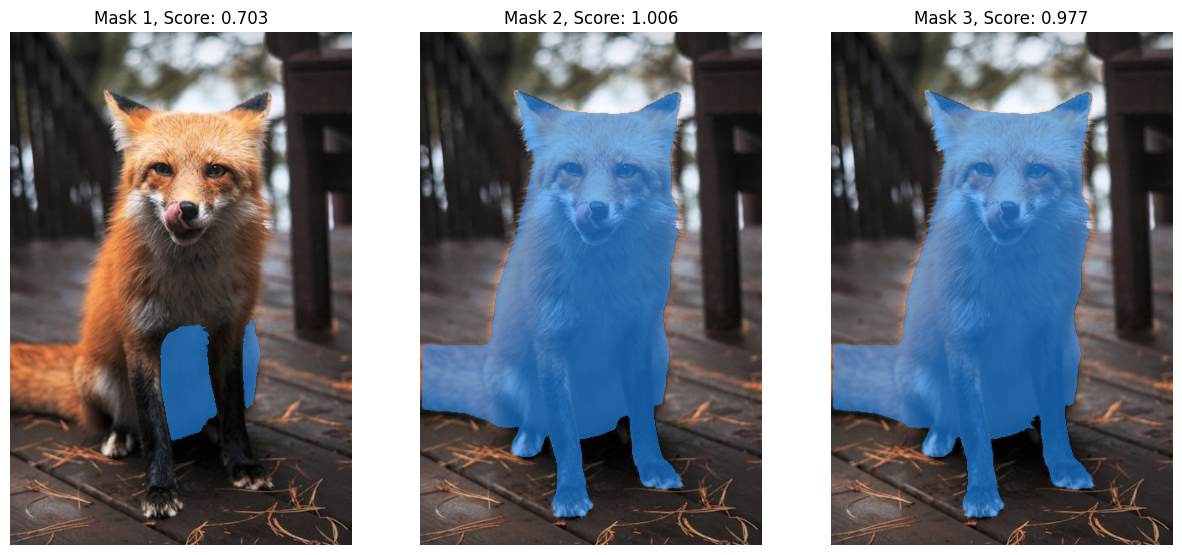

In [11]:
show_masks_on_image(image, masks_[0], scores)

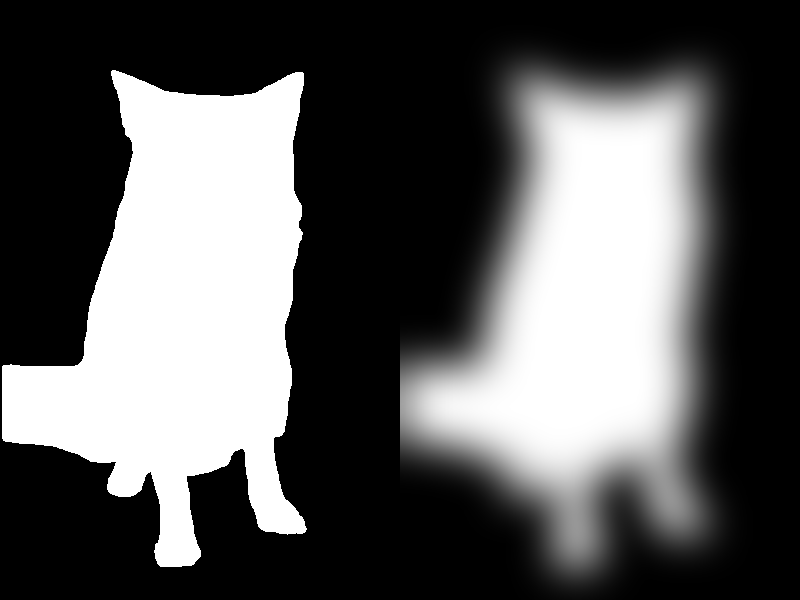

In [21]:
# By default SAM produces "multi masks" but we only care about one.
masks = masks_[0][0]
max_score_index = torch.argmax(scores).item()
best_mask = masks[max_score_index]

binary_mask = (best_mask > 0.5).float()
binary_mask_8bit = (binary_mask * 255).byte()

mask_image = Image.fromarray(binary_mask_8bit.cpu().numpy(), mode='L')
mask_image = mask_image.resize(image.size)

blurred_mask_image = mask_image.filter(ImageFilter.GaussianBlur(20))

make_image_grid([mask_image, blurred_mask_image], rows=1, cols=2)

In [40]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# "cinematic real photo of a black cat, film, professional, 4k, highly detailed, photo realistic, alive",
#     "cinematic photo realistic photo of a fox terrier dog, 4k, real, alive, extremely detailed, alive, real",

def base_prompt(thing):
  return f"cinematic real photo of a {thing}, film, professional, 4k, real, alive, extremely detailed, real, photo realistic"

prompts = [
    base_prompt("black cat"),
    base_prompt("fox terrier dog"),
    base_prompt("goat"),
    base_prompt("human baby"),
    ]

negative_prompt = "bad anatomy, deformed, ugly, disfigured, blurry"

def process_prompt(prompt):
  return inpainting_pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=image,
    mask_image=blurred_mask_image,
    num_inference_steps=50,
    width=image.size[0],
    height=image.size[1],

    # Customize these
    guidance_scale=7.0
  )

results = []
for prompt in prompts:
  results.append(process_prompt(prompt))

# TODO: for some reason, executing those in parallel creates weird results, like there is some artifact that's stored in the model and shared between executions.
# For now processing these synchronously yields best result.
# with ThreadPoolExecutor() as executor:
#     # Submit tasks to the executor
#     future_to_prompt = {executor.submit(process_prompt, prompt): prompt for prompt in prompts}

#     results = []
#     for future in as_completed(future_to_prompt):
#         try:
#             results.append(future.result())  # Collect the result
#         except Exception as e:
#             print(f"Error processing prompt {future_to_prompt[future]}: {e}")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

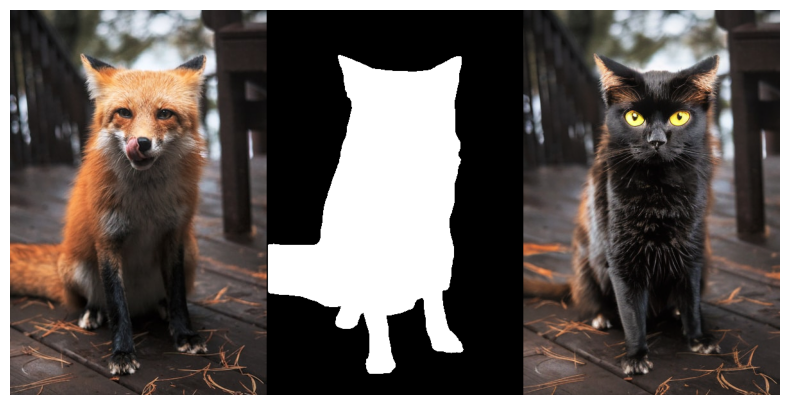

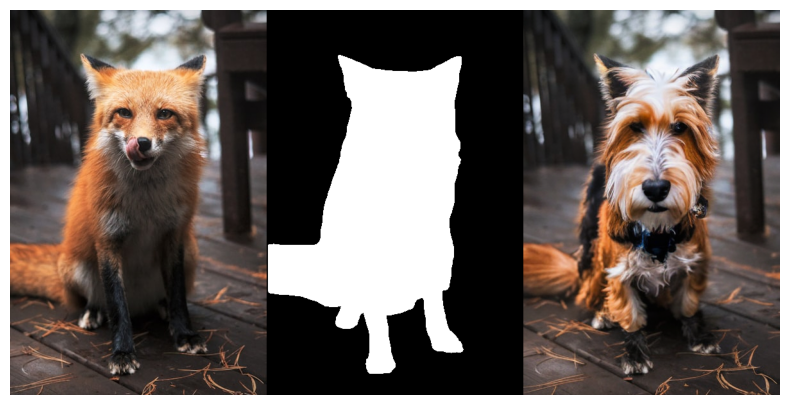

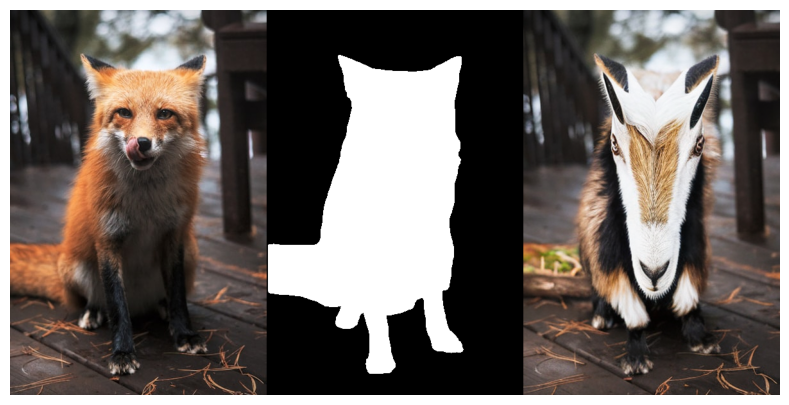

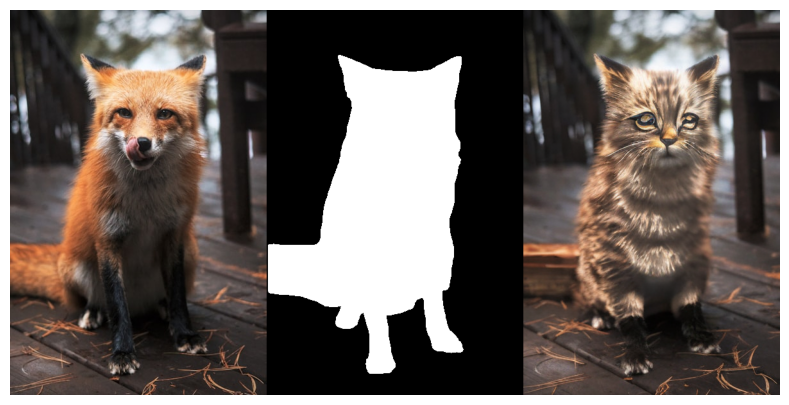

In [41]:
import matplotlib.pyplot as plt

for result in results:
    grid = make_image_grid([image, mask_image, result.images[0]], rows=1, cols=3)

    # Display the grid using matplotlib
    plt.figure(figsize=(15, 5))  # Adjust figure size as needed
    plt.imshow(grid)
    plt.axis('off')  # Hide axes for a cleaner display
    plt.show()